Pri risanju grafov si lahko pomagaš z:
https://matplotlib.org/tutorials/introductory/sample_plots.html
<br />
Za izračun moving average (bolj gladke grafe) poglej:
https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
<br />
Slovar v numpy structured array:
https://stackoverflow.com/questions/15579649/python-dict-to-numpy-structured-array
<br />
Kako spravit dve črti na en graf:
https://medium.com/@samchaaa/how-to-plot-two-different-scales-on-one-plot-in-matplotlib-with-legend-46554ba5915a

In [1]:
from csv import DictReader
from collections import defaultdict
import numpy as np
from operator import itemgetter
from datetime import datetime
import time

articles_list = []
bitcoin_list = []

reader = DictReader(open('articles.csv', 'rt', encoding='utf-8'))
for row in reader:
    articles_list.append({
        "uri": row["uri"],
        "source": row["source"],
        "title": row["title"], 
        "lang": row["lang"],
        "date": row["date"],
        "dateTime": row["dateTime"], 
        "dataType": row["dataType"], 
        "url": row["url"]
    })
    
reader = DictReader(open('crypto_data.csv', 'rt', encoding='utf-8'))
for row in reader:
    bitcoin_list.append({
        "time": row["time"],
        "close": row["close"],
        "volumeto": row["volumeto"]
    })
    
print("Done loading data!")

Done loading data!


In [2]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

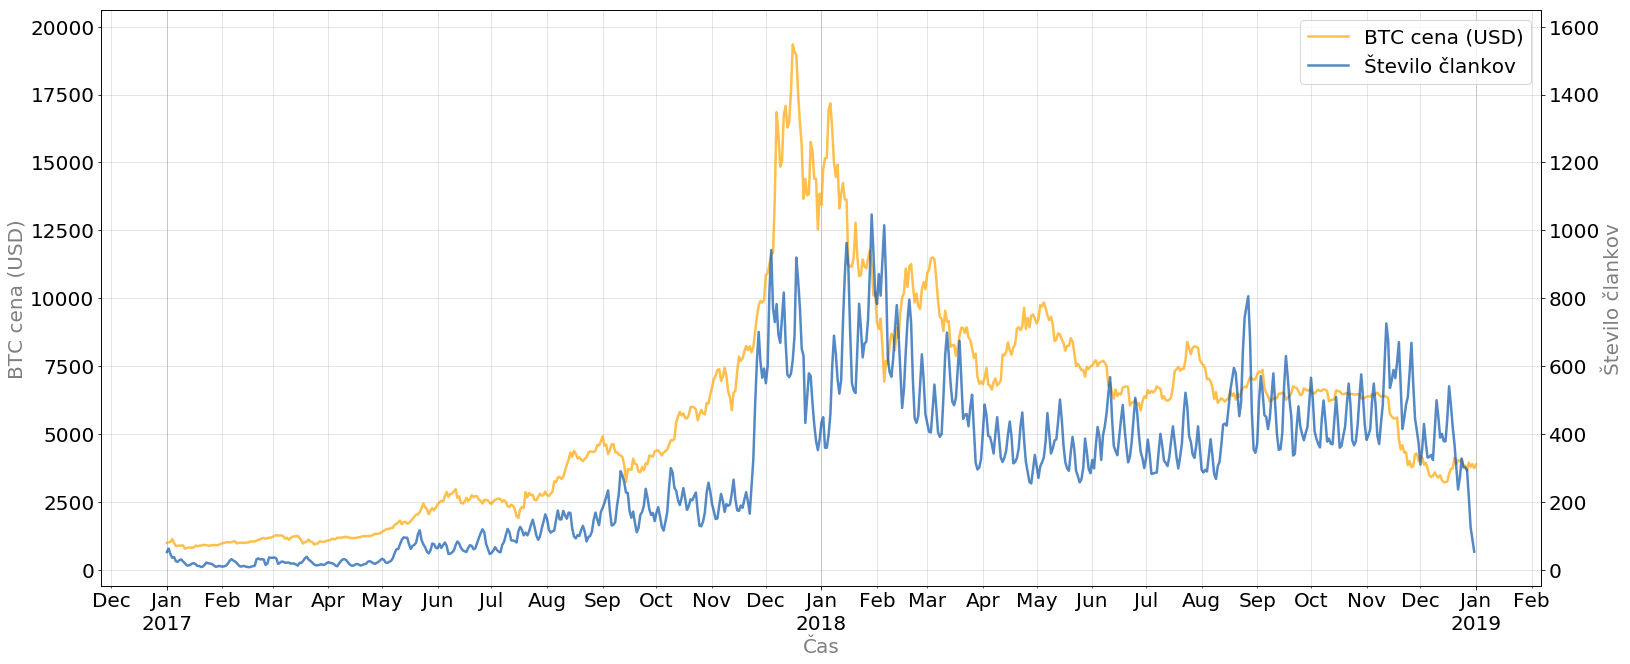

In [202]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

articles_per_day_dict = defaultdict(int)

for article in articles_list:
    date = article["date"]
    articles_per_day_dict[date] += 1
    #print(date)
    
articlesDtype = np.dtype([('date', 'datetime64[D]'), ('counter', 'i4')])
articlesValues = list(articles_per_day_dict.items())

articles_per_day = np.array(articlesValues, dtype=articlesDtype)

articles_per_day = np.sort(articles_per_day, order='date')

articles_per_day["counter"] = runningMeanFast(articles_per_day["counter"], 5)

#print(articles_per_day)

### Bitcoin ###
price_per_day = []

for day in bitcoin_list:
    date = time.ctime(int(day["time"]))
    date = datetime.strptime(date, "%a %b %d %H:%M:%S %Y")
    date = date.strftime("%Y-%m-%d")
    #print(date)
    price = float(day["close"])
    #print(price)
    price_per_day.append((date, price))

priceDtype = np.dtype([('date', 'datetime64[D]'), ('price', np.dtype(float))])
priceValues = price_per_day

price_per_day = np.array(priceValues, dtype=priceDtype)    
    
#print(price_per_day)
    
### Graph ###
ylabel_1 = 'BTC cena (USD)'
ylabel_2 = 'Število člankov'
#plt.rcParams['figure.figsize'] = [20, 10]

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

line_weight = 2.5
alpha = .7

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
monthsFmt = mdates.DateFormatter('%b')

#fig, ax = plt.subplots()
fig = plt.figure(figsize=(20, 8))

ax = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0, 0, 1, 1])

# This is the magic that joins the x-axis
ax2 = ax.twinx()

lns1 = ax.plot(price_per_day["date"], price_per_day["price"],
       color='orange', lw=line_weight, alpha=alpha, label=ylabel_1)

lns2 = ax2.plot(articles_per_day["date"], articles_per_day["counter"], 
        color='#0c57ad', lw=line_weight, alpha=alpha, label=ylabel_2)



# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(which='major', pad=25)

ax.xaxis.grid(which = 'minor', alpha = 0.4)
ax.xaxis.grid(which = 'major', alpha = 0.7)
ax.yaxis.grid(which = 'major', alpha = 0.4)

ax.yaxis.set_ticks(range(0, 20001, 2500))
ax2.yaxis.set_ticks(range(0, 1601, 200))

ax.set_ylim(-600, 20600)
ax2.set_ylim(-600/(20000/1600), 20600/(20000/1600))

ax.set_xlabel('Čas', fontsize=20)
ax.set_ylabel(ylabel_1, fontsize=20)
ax2.set_ylabel(ylabel_2, fontsize=20)

ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')
ax2.yaxis.label.set_color('grey')


#ax2.autoscale(enable=True, axis='y', tight=None)

#axis_font = {'fontname':'Arial', 'size':'18'}
#plt.xlabel("Čas", **axis_font)
#plt.ylabel("Cena BTC", **axis_font)

leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax.legend(leg, labs, loc=0, prop={'size': 20})

# round to nearest years...
#datemin = np.datetime64(articles_per_day["date"][0], 'Y')
#datemax = np.datetime64(articles_per_day["date"][-1], 'Y') + np.timedelta64(1, 'Y')
#ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '$%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
#fig.autofmt_xdate()
plt.savefig('output.png', dpi=300, bbox_inches='tight')
plt.show()

